In [39]:
import numpy as np
import pandas as pd
import os
import pickle
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
sys.path.append('/Users/ramtinyazdanian/PycharmProjects/job_skill_trend_analysis/')
from utilities.common_utils import *
from utilities.analysis_utils import *
from utilities.pandas_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scipy.stats import shapiro, anderson, probplot
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
root_data_path = '/Users/ramtinyazdanian/Downloads/jobtech/'
all_filenames = os.listdir(root_data_path)
all_dataframes = [pd.read_csv(os.path.join(root_data_path,filename)) 
                  for filename in all_filenames if filename[-3:] == 'csv' and filename[0] != '~']

In [3]:
df_all = pd.concat(all_dataframes)

In [4]:
df_all.head()

,jobId,jobUrl,jobTitle,jobDescription,datePosted,companyId,companyName,industryId,yoxMin,yoxMax,finalWageMin,finalWageMax,countryCode,skills,qualifications
0,0023502d439415ad8bbdb62a7020114c0e67ed5824e0b6...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
1,0053799fde5277b3ee431bb57f0820ef01a4c6abf7246d...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
2,009bd6514108fed114208aa85c28a2c318291978e301ee...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
3,00edb53a28e215cfb3f8d90594fac0872919bba772d842...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
4,01103f9a143bdecf5e09484315bd1a2fb36fe9e7acbca6...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']


In [5]:
df_all_useful_cols = df_all[['companyName', 'industryId', 'datePosted', 'skills']].rename(columns={
    'companyName': 'Company', 'industryId': 'Industry', 'datePosted': 'Date', 'skills': 'Skill List'
})

df_all_useful_cols['Skill List'] = df_all_useful_cols['Skill List'].apply(eval)
df_all_useful_cols['Date'] = pd.to_datetime(df_all_useful_cols['Date'])
company_totals = divide_into_periods(df_all_useful_cols, ['Company'], result_col_name='Total')

df_all_useful_cols = explode(df_all_useful_cols, ['Skill List'])
df_all_useful_cols = df_all_useful_cols.loc[df_all_useful_cols['Skill List'].apply(lambda x: x != '')]

df_all_useful_cols['Skill'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skill'])
df_all_useful_cols['Skill Type'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skillTypeId'])
df_all_useful_cols = df_all_useful_cols.drop(columns='Skill List')

In [6]:
df_all_useful_cols.head()

,Company,Date,Industry,Skill,Skill Type
0,MILWORKS SOLUTIONS PTE. LTD.,2020-01-01,InfoComm Technologies,accounts payable accounting,2
1,Red Hat,2018-01-01,InfoComm Technologies,virtualization technology,1
2,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,account management,2
3,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,business development,1
4,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,communication,4


If we want to filter out the irrelevant skill types (which I need to figure out), here is the place.

In [7]:
absolute_start = np.datetime64('2017-01-01')
absolute_end = np.datetime64('2020-01-01')

In [8]:
skills_df = divide_into_periods(df_all_useful_cols, ['Company', 'Skill'], 
                                absolute_start, absolute_end, result_col_name='Job Postings Raw')
skills_df = pd.merge(skills_df, company_totals, on = ['Company', 'Date'])
skills_df['Job Postings'] = skills_df['Job Postings Raw'] / skills_df['Total']

In [14]:
skills_df.sort_values('Date').head(10)

,Company,Skill,Date,Job Postings Raw,Total,Job Postings
194986,Netsense Business Solutions,business operations,2017-01-01,1,1,1.000000
279160,VOLTRIUM SYSTEMS PTE LTD,problem solving,2017-01-01,1,1,1.000000
279161,VOLTRIUM SYSTEMS PTE LTD,resourceful,2017-01-01,1,1,1.000000
279162,VOLTRIUM SYSTEMS PTE LTD,sales,2017-01-01,1,1,1.000000
279163,VOLTRIUM SYSTEMS PTE LTD,telecommunications,2017-01-01,1,1,1.000000
279164,VOLTRIUM SYSTEMS PTE LTD,vb,2017-01-01,1,1,1.000000
279165,VOLTRIUM SYSTEMS PTE LTD,willing to travel,2017-01-01,1,1,1.000000
19673,Agilent Technologies Singapore (International)...,javascript,2017-01-01,1,20,0.050000
19672,Agilent Technologies Singapore (International)...,japanese language,2017-01-01,1,20,0.050000
251351,Solarwinds Software Asia Pte Ltd,work shifts/irregular hours,2017-01-01,1,7,0.142857


In [9]:
monthly_totals = compute_total_values(skills_df)
total_log = compute_total_log_mean(skills_df)

In [10]:
start_and_end_dates = [(np.datetime64('2018-01-01'), np.datetime64('2019-01-01')), 
                       (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
                       (np.datetime64('2018-01-01'), np.datetime64('2020-01-01'))]
total_values = [get_period_of_time(monthly_totals, start_and_end_dates[i][0], start_and_end_dates[i][1]).sum()[0]
                for i in range(len(start_and_end_dates))]

In [13]:
skill_trends = [logsum_trend_slope_wrapper(skills_df, 
                                                  start_and_end_dates[i][0], start_and_end_dates[i][1],
                                                  total_log) for i in range(len(start_and_end_dates))]

Start: 2018-01-01
End: 2019-01-01
Number of skills: 1779
             Slope    Intercept  Acceleration    Spikiness
count  1779.000000  1779.000000   1779.000000  1779.000000
mean      0.257297     2.024744     21.654206    -2.797133
std       0.694567     7.794600    134.688898   223.935420
min      -0.515435    -1.789438     -8.559333 -7214.830030
25%      -0.002704    -0.641191     -0.011344    -6.416874
50%       0.046983    -0.288117      0.021950     5.741854
75%       0.198957     1.004670      0.993625     8.825856
max       8.339266   112.205171   3501.118692  5088.170589
Start: 2019-01-01
End: 2020-01-01
Number of skills: 1947
             Slope    Intercept  Acceleration     Spikiness
count  1947.000000  1947.000000   1947.000000   1947.000000
mean      0.109297     5.098714     13.001648    -93.312616
std       0.477435    16.353183     94.328421   1019.484343
min      -0.911262    -1.452125   -103.551178 -13422.098414
25%      -0.036599    -0.566693     -0.047402    -16.71

In [26]:
skill_trends[0].sort_values('Slope', ascending=False).head(20)

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Skill,,,,,
communication,8.339266,112.205171,3501.118692,6.182881,5241
creative thinking,5.839638,51.759699,1246.139046,6.706084,2688
sales,5.585375,92.367777,1854.154345,6.174248,3776
team player,5.229451,74.430501,1327.491064,5.359046,2974
marketing,5.107754,48.891825,1054.760705,7.175517,2273
meticulous,5.089531,67.131476,1249.410845,6.208125,2594
motivated,4.910826,64.762924,1151.868696,5.901719,2617
leadership,4.679331,40.446678,758.049829,6.270344,2027
strategic thinking,4.499792,37.703492,723.072347,7.077016,2060


In [21]:
skill_trends[1].corr(method='pearson')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,0.728744,0.829678,0.016633,0.775905
Intercept,0.728744,1.000000,0.787611,0.034212,0.985171
Acceleration,0.829678,0.787611,1.000000,0.013165,0.843001
Spikiness,0.016633,0.034212,0.013165,1.000000,0.028966
Job Postings Raw,0.775905,0.985171,0.843001,0.028966,1.000000


In [22]:
skill_trends[1].corr(method='spearman')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,-0.004140,0.671049,-0.060807,0.255656
Intercept,-0.004140,1.000000,0.145318,0.223003,0.908577
Acceleration,0.671049,0.145318,1.000000,-0.110898,0.184506
Spikiness,-0.060807,0.223003,-0.110898,1.000000,0.314487
Job Postings Raw,0.255656,0.908577,0.184506,0.314487,1.000000


In [27]:
emerging_skills = [threshold_logsum_trends_simple(skill_trends[i], total=total_values[i], slope_percentile_thresh=.8) 
                        for i in range(len(skill_trends))]

In [28]:
compare_emerging_skill_sets(emerging_skills, start_and_end_dates)


Comparing 2018-01-01 to 2019-01-01 with 2019-01-01 to 2020-01-01

# of skills shared and exclusive to each date (in order)
26 112 150

The skills themselves:

Shared:

{'microsoft office 365', 'social media (whatsapp)', 'search-engine marketing', 'accident and incident response management', 'terraform', 'ruby', 'confluence', 'corporate communications', 'financial audit', 'publishing', 'photography', 'lifelong learning', 'service oriented architecture', 'enterprise web architecture', 'dynamic host configuration protocol', 'channel management', 'architectural design', 'teaching', 'mpls', 'practical malware analysis', 'support process', 'full stack development', 'google analytics', 'quality of service (qos)', 'mac os', 'journalism'}

Exclusive to 2018-01-01 to 2019-01-01

{'cisco webex', 'crisis management', 'data structure', 'product design', 'shell scripts', 'data wrangling', 'financial system', 'industrial design', 'front-end development', 'search engine optimization (seo)', 'partners

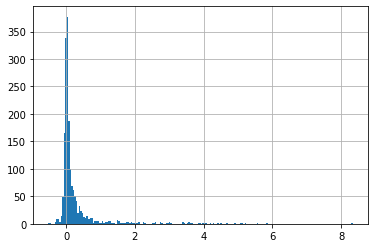

In [34]:
skill_trends[0].Slope.hist(bins=200)

Interestingly, as this plot and the summary statistics show, the Slope values are way more skewed to the right here, and the Generalised Normals that we had used before will fail.

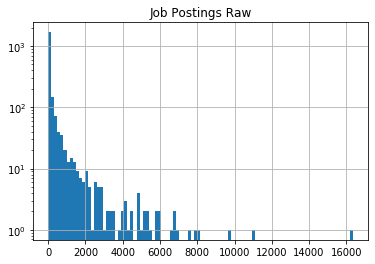

In [35]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().\
                        hist(bins = 100)
plt.yscale('log')

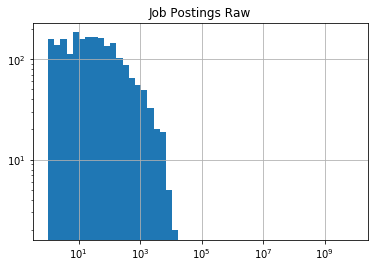

In [38]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().\
                        hist(bins = np.logspace(np.log(1), np.log(20000), 50))
plt.yscale('log')
plt.xscale('log')

((array([-2.74960467, -2.51759973, -2.38868915, ...,  3.16005943,
          3.29518963,  3.53905541]),
  array([-0.51543461, -0.45090296, -0.32741499, ...,  5.58537533,
          5.83963786,  8.3392656 ])),
 (0.5039840005675382, 0.07746953852353097, 0.6768923146952532))

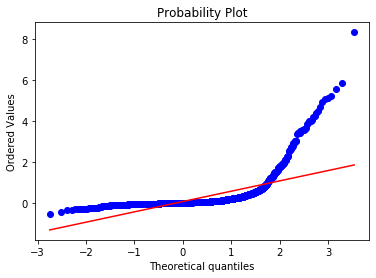

In [90]:
probplot(skill_trends[0].Slope.values, dist=stats.skewnorm, 
         sparams=(.5), fit=True, plot=plt)

((array([3.72840900e-18, 3.14160141e-16, 3.23649076e-15, ...,
         3.82818706e+00, 4.22771036e+00, 4.99957545e+00]),
  array([-0.91126191, -0.76629827, -0.74823349, ...,  4.27940094,
          4.76970007,  5.23202431])),
 (1.0418927208432172, -0.09835241842808586, 0.9632096449240837))

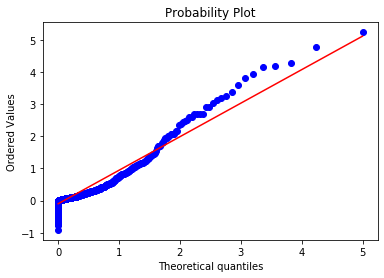

In [114]:
probplot(skill_trends[1].Slope.values, dist=stats.gamma, 
         sparams=(.2), fit=True, plot=plt)

So the tail of the slope is very Gamma-ey, but it's not a Gamma because slopes can be negative. This can be solved by using a skewed Laplace distribution.

((array([0.1293851 , 0.16669401, 0.19045893, ..., 5.25047581, 5.99901562,
         7.72886535]),
  array([-0.51543461, -0.45090296, -0.32741499, ...,  5.58537533,
          5.83963786,  8.3392656 ])),
 (1.2498565143218137, -1.101599628625025, 0.931641391619229))

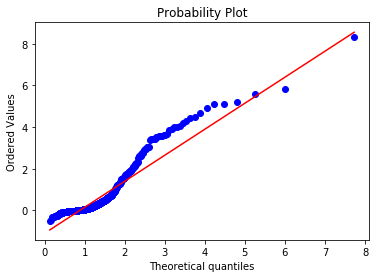

In [107]:
probplot(skill_trends[0].Slope.values, dist=stats.loglaplace, 
         sparams=(3.5), fit=True, plot=plt)

In [81]:
anderson(skill_trends[0].Slope.values, dist='gumbel_r')

AndersonResult(statistic=166.07368708273384, critical_values=array([0.472, 0.634, 0.753, 0.873, 1.033]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ]))